# Convergence in Hamiltonian Monte Carlo

Importing all needed libraries


In [9]:
%matplotlib notebook

import math
import random

# Numerics
import numpy as np
from numpy.linalg import inv
from scipy.misc import derivative # fd derivative

# Plotting
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm

In [10]:
mpl.rcParams['font.size'] = 16

Defining a regular grid

In [11]:
m1 = np.linspace(0,10,41)
m2 = np.linspace(0,10,51)
m1, m2 = np.meshgrid(m1,m2)

# This is a neat little trick that allows us to do really fast numpy stuff! Creating stacks of vectors allows
# us to perform matrix-vector operations on the last two dimensions of ND objects.
m_grid = np.stack((m1,m2))
m_grid = np.expand_dims(m_grid, axis=1)

# The stack option only stacks in the wrong order, no problem though for numpy!
m_grid = np.swapaxes(m_grid, 0, 2)
m_grid = np.swapaxes(m_grid, 1, 3)
del(m1, m2) # <- be nice to Python for once!

Defining quadratic misfit function

In [12]:
def misfit_multivariate_gaussian(m, invCovariance, mu):
    if m.ndim == 4:
        return np.squeeze(0.5 * np.matmul((m - mu).transpose(0,1,3,2), np.matmul(invCovariance, m - mu)))
    else:
        return np.squeeze(0.5 * np.matmul((m - mu).transpose(1,0), np.matmul(invCovariance, m - mu)))
    
def gradient_misfit_multivariate_gaussian(m, invCovariance, mu):
    return np.matmul(invCovariance, m - mu)

In [13]:
def integrate(m, p, invMass, invCovariance, means, n, epsilon):
    
    dm = gradient_misfit_multivariate_gaussian(m, invCovariance, means)
    
    # add first location to accumulator
    m_arr = m
    # first half-leapfrog step and add new momentum to accumulator
    p = p - (epsilon / 2) * dm
    p_arr = p
    
    for i in range(n):
        
        # Leapfrog 
        m  = m + epsilon * (invMass @ p)
        dm = gradient_misfit_multivariate_gaussian(m, invCovariance, means)
        p  = p - epsilon * dm
        
        # add to accumulator
        m_arr = np.hstack((m_arr, m))
        p_arr = np.hstack((p_arr, p))
                     
    return m_arr, p_arr

In [14]:
def proposeP(COV):
    p = np.ndarray(shape=(2,1))
    p[0], p[1] = np.random.multivariate_normal([0, 0], COV, 1).T    
    return p
    
def sample(n, covariance, means, steps, epsilon, mass):
    m = np.ndarray(shape=(2,1))
    m_new = np.ndarray(shape=(2,1))
    m[0] = 1
    m[1] = 9

    p = np.ndarray(shape=(2,1))
    p_new = np.ndarray(shape=(2,1))
    
    samples = m
    
    invMass = inv(mass)
    invCovariance = inv(covariance)
    
    for i in range(n):
        # Propose mass
        p = proposeP(mass)
        
        # Integrate Hamiltonian dynamics
        m_arr, p_arr = integrate(m, p, 
                                 invMass, 
                                 invCovariance, means, 
                                 random.randint(steps-1,steps+1), epsilon)
        
        # Saving last point
        m_new[0] = m_arr[0,-1]
        m_new[1] = m_arr[1,-1]
        p_new[0] = p_arr[0,-1]
        p_new[1] = p_arr[1,-1]
        
        X = misfit_multivariate_gaussian(m, invCovariance, means)
        X_new = misfit_multivariate_gaussian(m_new, invCovariance, means)
        
        K = np.asscalar(0.5 * p.T @ (invMass @ p))
        K_new = np.asscalar(0.5 * p_new.T @ (invMass @ p_new))
        
        H = X + K
        H_new = X_new + K_new
        
        if (H_new < H or np.exp(H - H_new) > np.random.uniform(low=0.0, high=1.0) ):
            m = m_new
            samples = np.hstack((samples, m))
    
    return samples

covariance = np.asarray(np.matrix('1.0 0.0; 0.0 1.0'))
means = np.asarray(np.matrix('5; 5'))
massMatrix = inv(covariance)
massMatrix[0,0]=1.0
massMatrix[1,0]=0.0
massMatrix[0,1]=0.0
massMatrix[1,1]=50.0

m_arr1 = sample(5000, covariance, means, 10, 1e-1, massMatrix)

<IPython.core.display.Javascript object>


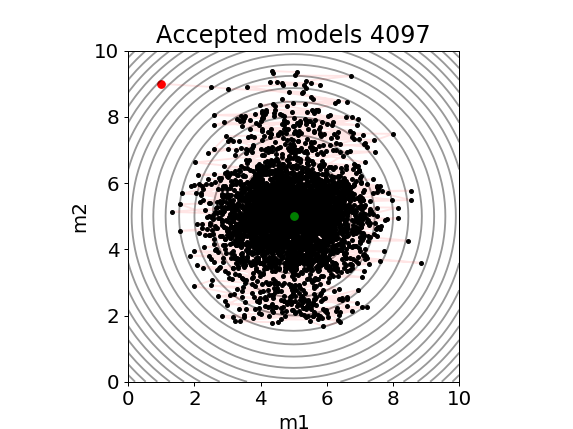

In [15]:
fig = plt.figure()

plt.scatter([1], [9], marker='o', color='r')
plt.scatter([m_arr1[0,1:]], [m_arr1[1,1:]], marker='.', color='k',zorder=3)
plt.plot(m_arr1[0,:], m_arr1[1,:], color='r', zorder=2,alpha=0.1)
plt.title("Accepted models %i" % int(m_arr1.size/2 - 1))
plt.scatter([5], [5], marker='o', color='g', zorder=10)

X = misfit_multivariate_gaussian(m_grid, inv(covariance), means)
plt.contour(m_grid[:,:,0,0], m_grid[:,:,1,0], X, 20, colors='k', alpha=0.4);
plt.xlim([0,10])
plt.axis('square')
plt.xlabel('m1')
plt.ylabel('m2')
plt.savefig('autocorrelatedSamples.pdf')

In [16]:
np.savetxt("samples.txt",m_arr1.T)